<a href="https://colab.research.google.com/github/ADITYADEB072003/ML-project/blob/main/Sales_Forecast_Prediction_Pythonipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

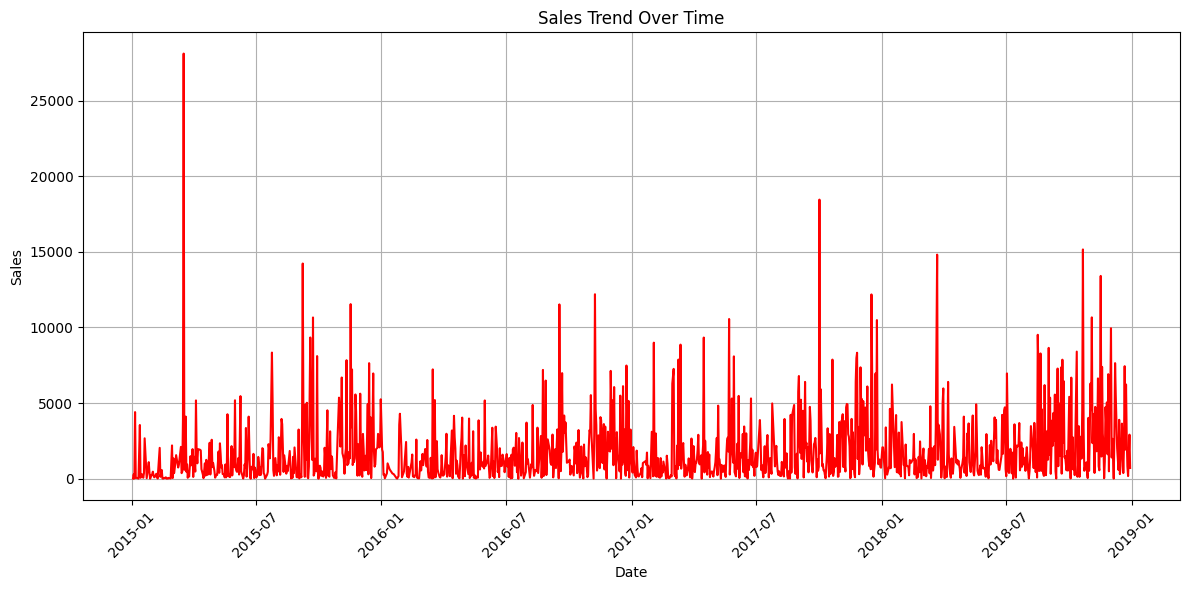

RMSE: 2593.23


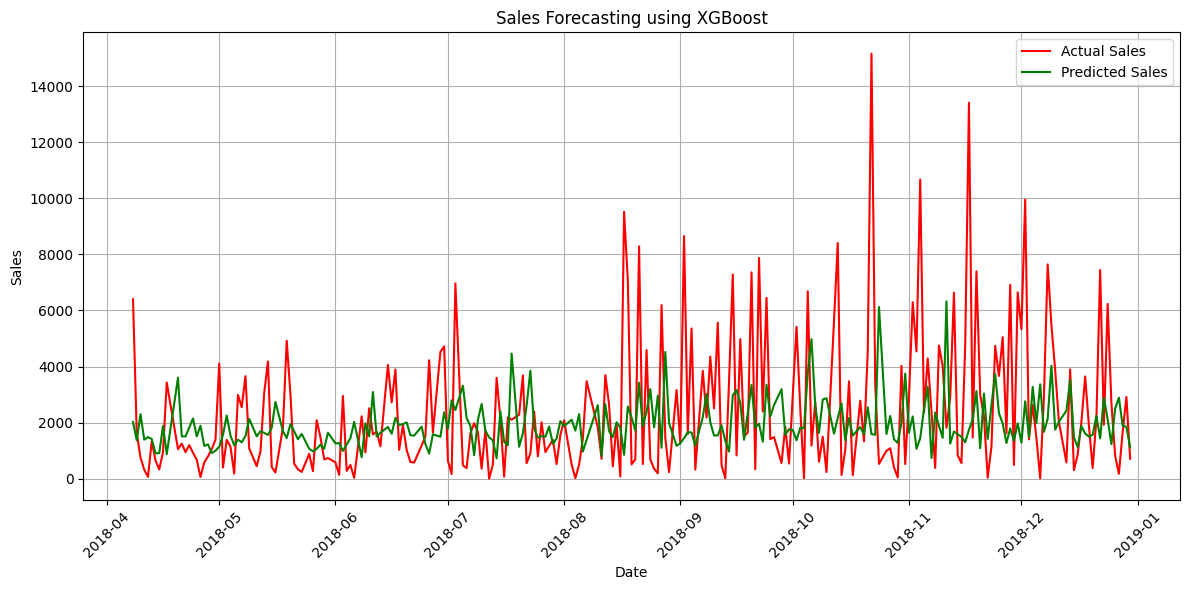

<Figure size 800x500 with 0 Axes>

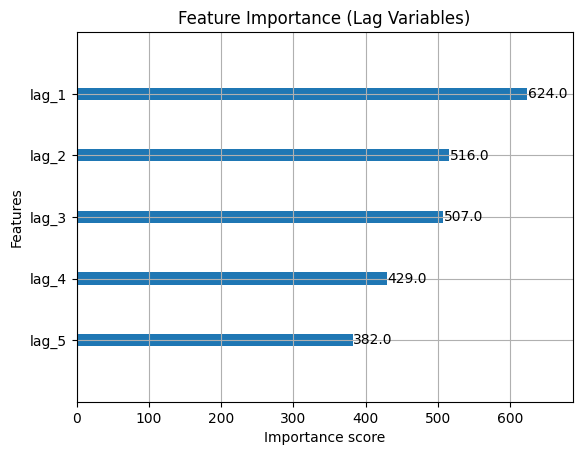

In [1]:
# ==========================================
# SALES FORECASTING USING XGBOOST
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# ==========================================
# 1. LOAD DATA
# ==========================================

file_path = 'train.csv'
data = pd.read_csv(file_path)

# Convert Order Date
data['Order Date'] = pd.to_datetime(data['Order Date'], format='%d/%m/%Y')

# ==========================================
# 2. AGGREGATE SALES BY DATE
# ==========================================

sales_by_date = data.groupby('Order Date')['Sales'].sum().reset_index()
sales_by_date = sales_by_date.sort_values('Order Date')

# ==========================================
# 3. PLOT SALES TREND
# ==========================================

plt.figure(figsize=(12,6))
plt.plot(sales_by_date['Order Date'], sales_by_date['Sales'], color='red')
plt.title("Sales Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ==========================================
# 4. CREATE LAG FEATURES
# ==========================================

def create_lagged_features(df, lag=5):
    df = df.copy()
    for i in range(1, lag+1):
        df[f'lag_{i}'] = df['Sales'].shift(i)
    return df

lag = 5
sales_lagged = create_lagged_features(sales_by_date, lag)
sales_lagged = sales_lagged.dropna()

# ==========================================
# 5. TRAIN-TEST SPLIT (TIME SERIES SAFE)
# ==========================================

X = sales_lagged.drop(columns=['Order Date', 'Sales'])
y = sales_lagged['Sales']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=False
)

# ==========================================
# 6. TRAIN XGBOOST MODEL
# ==========================================

model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4
)

model_xgb.fit(X_train, y_train)

# ==========================================
# 7. PREDICTION & RMSE
# ==========================================

predictions = model_xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE: {rmse:.2f}")

# ==========================================
# 8. PLOT ACTUAL VS PREDICTED
# ==========================================

plt.figure(figsize=(12,6))
plt.plot(sales_lagged['Order Date'].iloc[-len(y_test):],
         y_test.values, label="Actual Sales", color="red")

plt.plot(sales_lagged['Order Date'].iloc[-len(y_test):],
         predictions, label="Predicted Sales", color="green")

plt.title("Sales Forecasting using XGBoost")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ==========================================
# 9. FEATURE IMPORTANCE
# ==========================================

plt.figure(figsize=(8,5))
xgb.plot_importance(model_xgb)
plt.title("Feature Importance (Lag Variables)")
plt.show()